# Using Python for Research: Final Project

## Introduction
_(this introductory text was partially copied from the Final Project Instructions page)_

In this final project, we'll attempt to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. 

### _Input Data_

The input data used for training in this project consists of two files. The first file, `train_time_series.csv`, contains the raw accelerometer data, which has the following format:

`timestamp, UTC time, accuracy, x, y, z`

The second file, `train_labels.csv`, contains the activity labels numbered with integers: 

`1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up` 

Because the accelerometers are sampled at high frequency, the labels in `train_labels.csv` are only provided for every 10th observation in `train_time_series.csv`.



### _Project Goals_

#### Activity Classification

Our goal is to classify different physical activities as accurately as possible. At the end of the project we'll need to provide the activity labels predicted by our code for the test data set in `test_time_series.csv`. 

We need to upload our predictions as a CSV file called `test_labels.csv`, which originally only contains the time stamps needed for prediction; we'll need to augment this file by adding the corresponding class predictions (`1,2,3,4`).

#### Code Run Time

In addition, we also need to measure the running time of our code, starting from loading in the test data set and ending right after computing our predictions. 

### _Methods_

To accomplish this task, we need to
- load all data files into dataframes, and check their contents 
- clean the data: keep only the necessary columns and rows
- additionally, since the `x` and `y` variables both signify horizontal dimensions, therefore they play the same role in determining the outcome (standing, walking, stairs down, stairs up), and can be replaced with a more general `h` (horizontal acceleration) column
- visualize the data to determine if any other pre-processing steps are necessary 
- execute necessary pre-processing steps
- split the available training data and labels to training and validation datasets for internal validation
- fit and evaluate various models to see which has the highest accuracy
- use the highest accuracy model to make predictions on the test data set
- save these predictions

## Implementation

### _Load All Necessary Modules and Data Files_

First, let's import the necessary modules, load our input files and check their sizes and content.

In [1]:
import pandas as pd
import numpy as np
import scipy
import time 
import math

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

import matplotlib.pyplot as plt

start_time = time.time()

# load the training and test data files
df_input  = pd.read_csv("train_time_series.csv", index_col=0)
df_labels = pd.read_csv("train_labels.csv", index_col=0)
df_test_input  = pd.read_csv("test_time_series.csv", index_col=0)
df_test_labels = pd.read_csv("test_labels.csv", index_col=0)

# print the # of rows and last few rows of the training input data
print('Input data size: {}'.format(len(df_input)))
print('\nInput data sample:\n {}\n\n'.format(df_input.tail()))

# the 'accuracy' column is a bit suspicious
print('Unique accuracy values: {}\n\n'.format(df_input.accuracy.unique()))

# just out of curiosity
print('Unique label values: {}\n\n'.format(df_labels.label.unique()))

# print the # of rows and last few rows of the training label data
print('Label data size: {}'.format(len(df_labels)))
print('\nLabel data sample:\n {}'.format(df_labels.tail()))

# print the # of rows and last few rows of the test input data
print('\n\nTest input data size: {}'.format(len(df_test_input)))
print('\nTest input data sample:\n {}\n\n'.format(df_test_input.tail()))

# print the # of rows and last few rows of the test label data
print('Test label data size: {}'.format(len(df_test_labels)))
print('\nTest label data sample:\n {}'.format(df_test_labels.tail()))


Input data size: 3744

Input data sample:
            timestamp                 UTC time accuracy         x         y  \
24325  1565110305638  2019-08-06T16:51:45.638  unknown  0.024384 -0.710709   
24326  1565110305738  2019-08-06T16:51:45.738  unknown  0.487228 -1.099136   
24327  1565110305838  2019-08-06T16:51:45.838  unknown  0.369446 -0.968506   
24328  1565110305939  2019-08-06T16:51:45.939  unknown  0.167877 -0.802826   
24329  1565110306039  2019-08-06T16:51:46.039  unknown  0.689346 -0.991043   

              z  
24325  0.030304  
24326 -0.015213  
24327  0.036713  
24328  0.049805  
24329  0.034973  


Unique accuracy values: ['unknown']


Unique label values: [1 2 4 3]


Label data size: 375

Label data sample:
            timestamp                 UTC time  label
24289  1565110302030  2019-08-06T16:51:42.030      4
24299  1565110303032  2019-08-06T16:51:43.032      4
24309  1565110304034  2019-08-06T16:51:44.034      4
24319  1565110305037  2019-08-06T16:51:45.037      4


### _Clean and Pre-process the Data_

Next, we should clean up the data, keeping only the necessary columns and making sure that each row has numerical data.

From the above output we can see that the `UTC time` column is redundant in both dataframes, and the `accuracy` column has no meaningful data in it, so we have nothing to gain by keeping these columns. 

In [2]:
df_input.drop(columns=['UTC time', 'accuracy'], inplace=True)
df_labels.drop(columns=['UTC time'], inplace=True)

# check if the above instructions were successful, and if the new tables have non-numerical values
print('Input data content:\n{}\n\n'.format(df_input.tail()))
print('# of NaN values in input data by column:\n{}\n\n'.format(df_input.isna().sum()))

print('Label data content:\n{}\n\n'.format(df_labels.tail()))
print('# of NaN values in label data by column:\n{}\n\n'.format(df_labels.isna().sum()))

Input data content:
           timestamp         x         y         z
24325  1565110305638  0.024384 -0.710709  0.030304
24326  1565110305738  0.487228 -1.099136 -0.015213
24327  1565110305838  0.369446 -0.968506  0.036713
24328  1565110305939  0.167877 -0.802826  0.049805
24329  1565110306039  0.689346 -0.991043  0.034973


# of NaN values in input data by column:
timestamp    0
x            0
y            0
z            0
dtype: int64


Label data content:
           timestamp  label
24289  1565110302030      4
24299  1565110303032      4
24309  1565110304034      4
24319  1565110305037      4
24329  1565110306039      4


# of NaN values in label data by column:
timestamp    0
label        0
dtype: int64




There are no NaN values in the dataframes, so we can keep all the rows. 

Next, let's add a column `h` for horizonal acceleration based on the pythagorean theorem, using the data in the `x` and `y` columns.

In [3]:
h_arr = np.sqrt(np.add(np.square(df_input.x), np.square(df_input.y))) 
df_input['h'] = h_arr

Since we only have label data for every tenth row in the input dataframe, and for some of our classifiers we can only use this data to fit them, we will need a method that returns a dataframe that only contains these labeled rows.

In [4]:

def keep_labeled_data_only(dfinput, dflabels, print_it=False):
    ''' Create a copy of the input data and drop all the rows 
        that we don't have labels for.
        dfinput  : input dataframe
        dflabels : dataframe containing the labels
        print_it : boolean - print # of rows in the new dataframe
        
        returns a new dataframe that only contains the labeled data
    '''
    ret_df = dfinput.copy()

    label_times = dflabels['timestamp'].tolist()
    for index, row in dfinput.iterrows():
        if row.timestamp not in label_times:
            ret_df.drop(index, inplace=True)
    if print_it:        
        print('Number of rows in the new dataframe: {}'.format(len(ret_df)))
    return ret_df

# we can use this method to create a new classifier input dataframe, 
# that only contains the rows that have corresponding labels
clf_input = keep_labeled_data_only(df_input, df_labels, print_it=True)    

Number of rows in the new dataframe: 375


That checks out. 

Alternatively, in order to use semi-supervised classifiers, we need a method to add rows in the labels dataframe for the missing labels, marking them with a label value `-1`.

In [5]:
def add_missing_labels(df, dflabels, print_it=False):
    ''' Create a copy of the input data and drop all the rows 
        that we don't have labels for.
        df       : input dataframe
        dflabels : dataframe containing the labels
        print_it : boolean - print # of rows in the new dataframe
        
        returns a new dataframe that only contains the labeled data
    '''
    ret_df = dflabels.copy()
    
    label_times = dflabels['timestamp'].tolist()
    for index, row in df.iterrows():
        if row.timestamp not in label_times:
            ret_df.loc[index] = { 'timestamp' : row.timestamp, 'label' : -1 }
    if print_it:        
        print('Number of rows in the new dataframe: {}'.format(len(ret_df)))
    return ret_df

clf_labels = add_missing_labels(df_input, df_labels, print_it=True)

Number of rows in the new dataframe: 3744


That checks out as well. 

Now, we can visualize the data to determine if any other pre-processing steps are necessary.

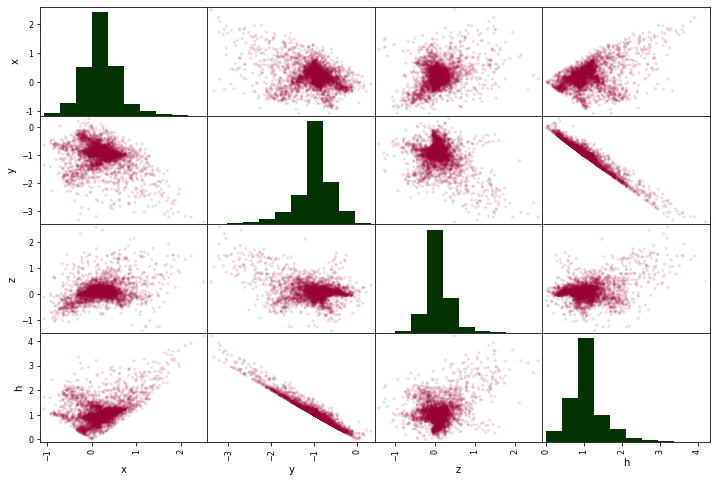

  Skewness for x : 0.6524946614509579
  Skewness for y : -1.2636879775619287
  Skewness for z : 1.2996195561840198
  Skewness for h : 1.54595461362232


In [6]:
# this code was adapted from our previous homework: HW5-1
outcomes   = ['x', 'y', 'z', 'h']

axes = pd.plotting.scatter_matrix(df_input[outcomes], alpha=0.15, figsize=(12, 8), \
       color=(0,0,0), hist_kwds={"color":(0,.2,0)}, facecolor=(.6,0,0.2))
# show the plot.
plt.show()
# determine the skew.
for column in outcomes:
    s = scipy.stats.skew(df_input[column])
    print('  Skewness for {} : {}'.format(column, s)) 

The components we are most interested in, `z` and `h` are both slightly right-skewed. To eliminate this skewness, we can use the `np.log10()` method, also, to make sure we are feeding non-zero values to this method, we add a small number to the original values (after eyeballing the above diagram and trying a few different values, `2.4` and `0.4` respectively seem to be optimal choices).

In [7]:
z_arr = np.log10(df_input['z'] +2.4)
h_arr = np.log10(df_input['h'] +0.4)
print('  Skewness for Z : {}'.format( scipy.stats.skew(z_arr))) 
print('  Skewness for H : {}'.format( scipy.stats.skew(h_arr))) 

df_input['z'] = z_arr
df_input['h'] = h_arr


  Skewness for Z : 0.018219903523700866
  Skewness for H : 0.013126452816084877


This can be done for the reduced size dataframe as well (in this case the optimal values seem to be `2.2` and `0.4`).

In [8]:
z_arr = np.log10(clf_input['z'] +2.2)
h_arr = np.log10(clf_input['h'] +0.4)
print('  Skewness for Z : {}'.format( scipy.stats.skew(z_arr))) 
print('  Skewness for H : {}'.format( scipy.stats.skew(h_arr))) 

clf_input['z'] = z_arr
clf_input['h'] = h_arr

  Skewness for Z : -0.014816821068750301
  Skewness for H : 0.017478026209477738


This concludes the necessary pre-processing steps. 

### _Find the Highest Accuracy Classifier_

Next, we need to split the available training data and labels to training and validation datasets for internal validation. 

Then, we can fit and evaluate various classifiers to see which one has the highest accuracy. The below classifiers and parameters were chosen based on this [documentation](https://scikit-learn.org/stable/modules/multiclass.html) .

First, let's examine how the below classifiers perform on the reduced input dataset.

In [9]:
import sys
import warnings

# supressing warnings about matrix dimensions as some of the classifiers 
# may require flattened matrices or transposed vectors
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# create a dictionary of classifiers we can loop through
classifiers = {}
classifiers['BernoulliNB'] = BernoulliNB()
classifiers['GaussianNB']  = GaussianNB()
classifiers['RidgeClassifier']  = RidgeClassifier()
classifiers['RidgeClassifier_chol'] = RidgeClassifier(solver='cholesky')
classifiers['LogisticRegression']   = LogisticRegression(solver='saga', multi_class='multinomial')

classifiers['RandomForestClassifier']     = RandomForestClassifier()
classifiers['RandomForestClassifier_ent'] = RandomForestClassifier(criterion='entropy')
classifiers['DecisionTreeClassifier']     = DecisionTreeClassifier()
classifiers['DecisionTreeClassifier_ent'] = DecisionTreeClassifier(criterion='entropy')
classifiers['ExtraTreeClassifier']        = ExtraTreeClassifier()
classifiers['ExtraTreeClassifier_ent']    = ExtraTreeClassifier(criterion='entropy')
classifiers['ExtraTreesClassifier']       = ExtraTreesClassifier()
classifiers['ExtraTreesClassifier_ent']   = ExtraTreesClassifier(criterion='entropy')

classifiers['QuadraticDiscriminantAnalysis'] = QuadraticDiscriminantAnalysis()


def test_classifiers(N=20, test_size=0.15, tree_depth=4, cutoff=.6):
    ''' This method tests a suit of classifiers on the same randomly split datasets,
        and prints out the average score for each classifier that scores above the cutoff value
        
        N          : number of random splits
        test_size  : proportion of the test dataset 
        tree_depth : maximum depth of tree/forest classifiers
        cutoff     : only print scores above a certain value (for easier eyeballing)
        
        No return value, just printing results
    '''
    # set maximum depth of tree/forest classifiers
    for key in classifiers.keys():
        if 'Tree' in key or 'Forest' in key:
            classifiers[key].set_params(max_depth=tree_depth)
            
    # create a similar dictionary for keeping scores        
    scores = {}    
    for key in classifiers.keys():
        scores[key] = []
     
    # create N randomly split training and test sets
    for ii in range(N):
        input_train, input_test, label_train, label_test = train_test_split(clf_input[[ 'z', 'h']], df_labels[['label']], 
                                                                            test_size=test_size, random_state=ii)
        # evaluate the classifiers for each dataset
        for key, classifier in classifiers.items():
            classifier.fit(input_train, label_train)
            score = classifier.score(input_test, label_test)
            scores[key].append(score)

    # calculate and print the average scores for each classifier 
    # that scores above the cutoff value
    for key, score_arr in scores.items(): 
        avg_score = np.mean(score_arr)
        if avg_score > cutoff:
            print('    Score for {}:     \t{:0.4}%'.format(key, avg_score*100))
        
# invoke the above method for various tree depth and test size values
for k in range(3,6):    
    print('\n\nTree Depth = {}'.format(k))
    for t in range(5, 11, 5):
        print('  Test size = {}%'.format(t))
        test_classifiers(N=20, test_size=t/100, tree_depth=k, cutoff=.6)  
              
print('\n\nDone testing!!\n')            



Tree Depth = 3
  Test size = 5%
    Score for RandomForestClassifier:     	61.32%
    Score for RandomForestClassifier_ent:     	62.89%
    Score for DecisionTreeClassifier_ent:     	64.47%
  Test size = 10%


Tree Depth = 4
  Test size = 5%
    Score for RandomForestClassifier:     	61.84%
    Score for RandomForestClassifier_ent:     	62.63%
    Score for DecisionTreeClassifier:     	61.58%
    Score for DecisionTreeClassifier_ent:     	61.84%
  Test size = 10%


Tree Depth = 5
  Test size = 5%
    Score for RandomForestClassifier:     	62.11%
    Score for RandomForestClassifier_ent:     	61.58%
  Test size = 10%


Done testing!!



Again, after trying several different parameters and eyeballing the output, we came to the conclusion that the `DecisionTreeClassifier` with `criterion='entropy', max_depth=3` initial parameters makes the most accurate predictions on this dataset, with an average accuracy score on 20 different randomly split datasets slightly above 60%. Close seconds are the `RandomForestClassifier` with or without `criterion='entropy'` and with `max_depth=4`.

Now, let's see how the semi-supervised classifiers fair on the datasets containing both labeled and unlabeled data.

In [10]:

def test_ss_classifiers(N=20, test_size=0.5):    
    ''' This method tests two semi-supervised classifiers, LabelPropagation and LabelSpreading,
        on the same randomly split datasets, and prints out their average score 
        
        N          : number of random splits
        test_size  : proportion of the test dataset 
        
        No return value, just printing results
    '''

    # create lists to keep scores for each classifier  
    prop_scores   = []
    spread_scores = []
    
    # create N randomly split training and test sets
    for ii in range(N):
        input_train, input_test, label_train, label_test = train_test_split(df_input[['timestamp', 'z', 'h']], 
                                                                            clf_labels[['timestamp', 'label']], 
                                                                            test_size=test_size, 
                                                                            random_state=ii)
        # keep only the labeled data for the test sets
        for index, row in label_test.iterrows():
            if row.label == -1:
                label_test.drop(index, inplace=True)

        input_test = keep_labeled_data_only(input_test, label_test)

        # the moment of truth
        label_prop.fit(input_train[['z', 'h']], label_train[['label']])
        score = label_prop.score(input_test[['z', 'h']], label_test[['label']])
        prop_scores.append(score)

        label_spread.fit(input_train[['z', 'h']], label_train[['label']])
        score = label_spread.score(input_test[['z', 'h']], label_test[['label']])
        spread_scores.append(score)
        
    print('  The accuracy score for LabelPropagation: {}'.format(np.mean(prop_scores)))
    print('  The accuracy score for LabelSpreading: {}'.format(np.mean(spread_scores)))



# instantiate the two semi-supervised classifiers
label_prop   = LabelPropagation()
label_spread = LabelSpreading()    
        
    
# make sure that the data in the extended dataset appears in the same order
# before calling te above function
df_input.sort_values('timestamp', inplace=True)
clf_labels.sort_values('timestamp', inplace=True)

for t in range(20, 51, 10):
    print('  Test size = {}%'.format(t))
    test_ss_classifiers(N=20, test_size=t/100)  

  Test size = 20%
  The accuracy score for LabelPropagation: 0.5766049778193746
  The accuracy score for LabelSpreading: 0.5766049778193746
  Test size = 30%
  The accuracy score for LabelPropagation: 0.5743662025399434
  The accuracy score for LabelSpreading: 0.5743662025399434
  Test size = 40%
  The accuracy score for LabelPropagation: 0.5739025386362908
  The accuracy score for LabelSpreading: 0.5739025386362908
  Test size = 50%
  The accuracy score for LabelPropagation: 0.570466932340178
  The accuracy score for LabelSpreading: 0.570466932340178


Unexpectedly, semi-supervised classifiers with similar test parameters only yielded about 57-58% accuracy, and they didn't perform better than `DecisionTreeClassifiers` or `RandomForestClassifiers` (unless I overlooked something). So our final choice of classifiers are still the `DecisionTreeClassifier` with `criterion='entropy', max_depth=3` initial parameters and the `RandomForestClassifier` with or without `criterion='entropy'` and with `max_depth=4` (since we can try up to ten different output label set). 

### _Use the Highest Accuracy Model to Make Predictions on the Test Dataset_

Before we can fit this classifier for the entire training dataset, and make predictions on the test data, we should perform the same prepocessing steps on the test datasets as we did on the training datasets. This includes: 

- keeping only data we have labels for
- adding a column `h` for horizontal acceleration (which actually seems to improve the performance of some of the above classifiers)
- checking and correcting for skewness

In [11]:
clf_test_input = keep_labeled_data_only(df_test_input, df_test_labels)

h_arr = np.sqrt(np.add(np.square(clf_test_input.x), np.square(clf_test_input.y))) 
clf_test_input['h'] = h_arr


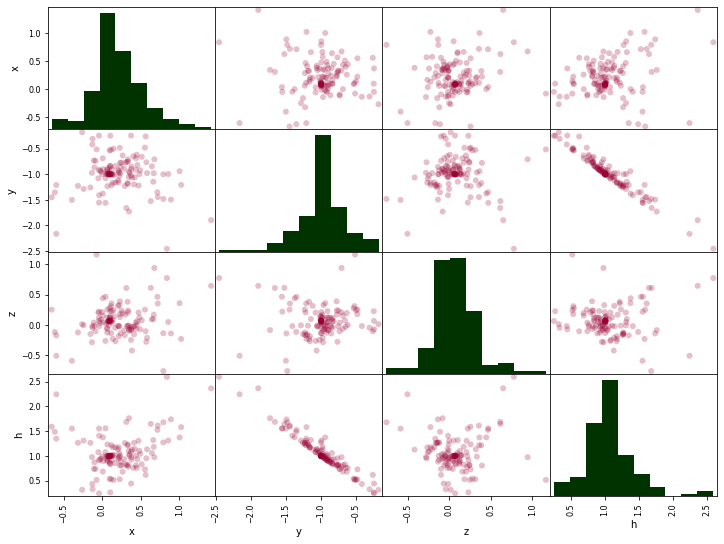

  Skewness for x : 0.32906346391739427
  Skewness for y : -0.7300576567658518
  Skewness for z : 0.7685738370966831
  Skewness for h : 1.0408286818796528


In [12]:
# this code was adapted from our previous homework: HW5-1
covariates = ['timestamp']
outcomes   = ['x', 'y', 'z', 'h']

axes = pd.plotting.scatter_matrix(clf_test_input[outcomes], alpha=0.25, figsize=(12, 9), \
       color=(0,0,0), hist_kwds={"color":(0,.2,0)}, facecolor=(.6,0,0.2), marker='o')
# show the plot.
plt.show()
# determine the skew.
for column in outcomes:
    s = scipy.stats.skew(clf_test_input[column])
    print('  Skewness for {} : {}'.format(column, s)) 

In [13]:
# adjusting for skewness using the same parameters as forthe training data
z_arr = np.log10(clf_test_input['z'] +2.2)
h_arr = np.log10(clf_test_input['h'] +0.4)
print('  Skewness for Z : {}'.format( scipy.stats.skew(z_arr))) 
print('  Skewness for H : {}'.format( scipy.stats.skew(h_arr))) 
clf_test_input['z'] = z_arr
clf_test_input['h'] = h_arr


  Skewness for Z : -0.05521924064271837
  Skewness for H : -0.3025804493240206


Now we can finally fit our three chosen classifiers and make predictions on the test data.

In [14]:
# create the three classifiers and perform the fitting on the training data
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dt_clf.fit(clf_input[[ 'z', 'h']], df_labels[['label']])

rf_clf = RandomForestClassifier(max_depth=4)
rf_clf.fit(clf_input[[ 'z', 'h']], df_labels[['label']])

rfe_clf = RandomForestClassifier(criterion='entropy', max_depth=4)
rfe_clf.fit(clf_input[[ 'z', 'h']], df_labels[['label']])

# make predictions with each classifier and add one of them to the dataframe
lab_arr = dt_clf.predict(clf_test_input[['z', 'h']])
df_test_labels['label'] = lab_arr

lab_arr = rf_clf.predict(clf_test_input[['z', 'h']])
#df_test_labels['label_rf'] = lab_arr

lab_arr = rfe_clf.predict(clf_test_input[['z', 'h']])
#df_test_labels['label_rfe'] = lab_arr

df_test_labels.to_csv('my_output_labels.csv', mode='w')
print(df_test_labels.head())


total_time = time.time() - start_time  
mins = math.floor(total_time / 60)
secs = total_time % 60
if mins > 0:
    print('\nTotal time: {} mins {:0.2f} secs'.format(mins, secs))
else:
    print('\nTotal time: {:0.2f} seconds'.format(secs))

           timestamp                 UTC time  label
24339  1565110307041  2019-08-06T16:51:47.041      2
24349  1565110308043  2019-08-06T16:51:48.043      1
24359  1565110309046  2019-08-06T16:51:49.046      2
24369  1565110310048  2019-08-06T16:51:50.048      2
24379  1565110311050  2019-08-06T16:51:51.050      2

Total time: 3 mins 6.93 secs



Total time on my machine (including testing the classifiers): 3 mins 9.66 secs

Total time on my machine (not including testing the classifiers): 12.12 seconds